In [1]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [2]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses
from __my_functions_flooddepth_houses import create_sample_houses_withinZone
from __my_functions_flooddepth_houses import calculate_first_qth_arrival_and_maxdepth
from __my_functions_flooddepth_houses import plot_flooddepth_houses_in_zone

### paths

In [3]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [4]:
general_path = 'E:/paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------

### load flood results

In [5]:
# ## flood scenario 
# scenario_name = 'scen1_voorpiek'
# simulation_name = 'lk_dh_test13_5verloop_2d'
# ## start_breach_time = '2000-01-01T18:00:00'
# start_breach_time = '2000-01-01T00:00:00'


scenario_name = 'scen2_napiek'
simulation_name = 'lk_dh_test14_5verloop_38h'
# start_breach_time = '2000-01-02T04:00:00'
start_breach_time = '2000-01-01T00:00:00'

In [6]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)

In [7]:
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 38.00862374799665 uur
aantal tijdstappen: 457
interval: 300.02, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


----------------

## load buurten and houses in area

In [8]:
# buurten_scen2_test = gpd.read_file(f'{input_path}/buurten_scen2_test.shp')
buurten_new = gpd.read_file(f'{input_path}/cbs_buurten_fix.shp')
# buurten_scen2_test.columns

In [9]:
houses_all = gpd.read_file(f'{input_path}/huizen_centroid_flood_area_cleaned.shp')

------------------------------------------------------------

##  Testing on one zone

In [ ]:
random_index = 30
selected_zone = buurten_new.iloc[random_index]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom

In [ ]:
# specifieke zone
buurt_naam = 'Buitengebied Schagerbrug-Noord'

#oude sluis
# selected_zone = buurten_scen2_test.loc[buurten_scen2_test.BU_CODE == 'BU04410901']
selected_zone = buurten_scen2_test.loc[buurten_scen2_test.BU_NAAM == buurt_naam]
selected_zone_geom = selected_zone.geometry
# selected_zone_geom.plot()

#### 1) create sample

In [ ]:
samplesize = 14
zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone )
print(f'zone name: {zone_name}')
houses_df.head(1)

#### 2)  compute flood depth(t)at this sample

In [ ]:
flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                houses_df, gr, time_humanized, last_timestamp, output_path)
len(flooddepth_time_houses_df)

In [ ]:
len(flooddepth_time_houses_df.columns)

In [ ]:
zones_depth_time_df =  pd.DataFrame( index = time_humanized)
zone_name = zone_name

for index, row in flooddepth_time_houses_df.iterrows():
    flooddepths = row.values
    max_depth_qt = np.quantile(flooddepths,0.95)
    
    zones_depth_time_df.loc[index, zone_name] = max_depth_qt
    
    
zones_depth_time_df    

#### 3)  compute one value first arrival and max depth for zone

In [ ]:
first_qth_arrival, max_depth, max_depth_qt = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df)
print(f'first arrival: {first_qth_arrival}')
# print(f'max depth: {max_depth}')
# print(f'max depth qt: {max_depth_qt}')


#### 4) plot flood depth in zone

In [ ]:
plot_flooddepth_houses_in_zone(zone_name,flooddepth_time_houses_df, first_qth_arrival,max_depth, max_depth_qt, time_humanized, output_path)

----------------------------

---------

## selection of zones

In [19]:
len_all_zones = len(buurten_new)
len_all_zones

89

#### choose sample size

In [20]:
nr_zones_sampling = 89
samplesize_nr_houses_in_zone = 50

In [21]:
selected_zones = buurten_new.sample(nr_zones_sampling)

In [22]:
def create_zones_maxdepth_arrival_df(houses_all, selected_zones, samplesize_nr_houses_in_zone, 
                                     scenario_name, gr, time_humanized, last_timestamp, output_path):
    
    #make df based on zone_selection
    zones_maxdepth_arrival_df = selected_zones[["BU_NAAM", 'geometry', 'AANT_INW']].copy()
    zones_maxdepth_arrival_df["maxdepth"] = np.nan
    zones_maxdepth_arrival_df["maxdepth_qt"] = np.nan
    zones_maxdepth_arrival_df["arrival"] = np.nan
    zones_maxdepth_arrival_df
    
    ## df with zones max depth over time
    zones_depth_time_df = pd.DataFrame( index = time_humanized)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    
    samplesize = samplesize_nr_houses_in_zone

    # loop over alle zones
    for index, row in zones_maxdepth_arrival_df.iterrows():
    
        gpd.GeoSeries(row.geometry).plot(ax=ax, color="#dee2e6")
        
        selected_zone = zones_maxdepth_arrival_df.loc[zones_maxdepth_arrival_df.BU_NAAM == row.BU_NAAM]
    

        #create sample for all seleced zones
        zone_name, houses_df = create_sample_houses_withinZone(samplesize, houses_all, selected_zone )
        

        #indien er geen huizen in de zone zijn, continue to next loop
        if len(houses_df) == 0:
            continue

        else:

            # compute flood depth(t)at this sample
            flooddepth_time_houses_df = create_df_flooddepth_houses(scenario_name, samplesize, zone_name,
                                                                    houses_df, gr, time_humanized, last_timestamp, output_path)

            ## continue when no depth
            if len(flooddepth_time_houses_df.columns) == 0:
                continue

            else:

                # compute one value first arrival and max depth for zone
                first_qth_arrival_dt, max_depth, max_depth_qt  = calculate_first_qth_arrival_and_maxdepth(flooddepth_time_houses_df, zone_name)

                print(first_qth_arrival_dt)
                print('----')
                if max_depth > 0:
                    zones_maxdepth_arrival_df.loc[index, "maxdepth"] = max_depth
                    zones_maxdepth_arrival_df.loc[index, "maxdepth_qt"] = max_depth_qt

                    
                if first_qth_arrival_dt != np.nan:
                    zones_maxdepth_arrival_df.loc[index, "arrival"] = first_qth_arrival_dt
                    
                
                ## fil zones_depth_time_df
                for index, row in flooddepth_time_houses_df.iterrows():
                    flooddepths = row.values
                    max_depth_qt_time = np.quantile(flooddepths,0.95)

                    zones_depth_time_df.loc[index, zone_name] = max_depth_qt_time


                  




                #plot flood depth in zone
                plot_flooddepth_houses_in_zone(zone_name, 
                                       flooddepth_time_houses_df, 
                                       first_qth_arrival_dt, 
                                       max_depth, 
                                       max_depth_qt, 
                                       time_humanized, 
                                        scenario_name,
                                       output_path)

    return zones_maxdepth_arrival_df, zones_depth_time_df

nr houses in 49    Blauwe Keet
Name: BU_NAAM, dtype: object: 49
all houses in zones taken
flood values for Blauwe Keet
----------------------
first_qth_arrival: 946688404.0
first_qth_arrival_dt: 2000-01-01 02:00:04
max_depth_qt : 1.5615532797897387
max_depth: 1.7086961638748073
2000-01-01 02:00:04
----
nr houses in 68    't Zand-West- en -Zuid
Name: BU_NAAM, dtype: object: 22
all houses in zones taken
nr houses in 54    Ooghduyne
Name: BU_NAAM, dtype: object: 1082
too many, therefor sample of 50 houses taken
flood values for Ooghduyne
----------------------
first_qth_arrival: 946693200.0
first_qth_arrival_dt: 2000-01-01 03:20:00
max_depth_qt : 1.0652562200181646
max_depth: 1.1627985528534563
2000-01-01 03:20:00
----
nr houses in 18    Fort Dirksz Admiraal
Name: BU_NAAM, dtype: object: 54
too many, therefor sample of 50 houses taken
flood values for Fort Dirksz Admiraal
----------------------
first_qth_arrival: 946683904.0
first_qth_arrival_dt: 2000-01-01 00:45:04
max_depth_qt : 1.39035

flood values for Marina
----------------------
first_qth_arrival: 946684804.0
first_qth_arrival_dt: 2000-01-01 01:00:04
max_depth_qt : 2.010958384071683
max_depth: 2.0398601098086173
2000-01-01 01:00:04
----
nr houses in 66    Oudesluis (woonkern)
Name: BU_NAAM, dtype: object: 437
too many, therefor sample of 50 houses taken
nan
----
nr houses in 34    Westoever
Name: BU_NAAM, dtype: object: 148
too many, therefor sample of 50 houses taken
flood values for Westoever
----------------------
first_qth_arrival: 946684204.0
first_qth_arrival_dt: 2000-01-01 00:50:04
max_depth_qt : 1.4484606296621667
max_depth: 1.8230863652850777
2000-01-01 00:50:04
----
nr houses in 4    Sluisdijk
Name: BU_NAAM, dtype: object: 531
too many, therefor sample of 50 houses taken
flood values for Sluisdijk
----------------------
first_qth_arrival: 946683304.0
first_qth_arrival_dt: 2000-01-01 00:35:04
max_depth_qt : 2.0846053457435283
max_depth: 2.472476451016325
2000-01-01 00:35:04
----
nr houses in 8    Vogelbuu

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 44    Julianadorp-Oost
Name: BU_NAAM, dtype: object: 493
too many, therefor sample of 50 houses taken
flood values for Julianadorp-Oost
----------------------
first_qth_arrival: 946693200.0
first_qth_arrival_dt: 2000-01-01 03:20:00
max_depth_qt : 1.2936911057768097
max_depth: 1.3536933505522424
2000-01-01 03:20:00
----
nr houses in 71    Buitengebied 't Zand-Oost
Name: BU_NAAM, dtype: object: 87
too many, therefor sample of 50 houses taken
nr houses in 48    Koegras-Noord
Name: BU_NAAM, dtype: object: 113
too many, therefor sample of 50 houses taken
flood values for Koegras-Noord
----------------------
first_qth_arrival: 946686964.0
first_qth_arrival_dt: 2000-01-01 01:36:04
max_depth_qt : 1.6974957378592186
max_depth: 1.8133093768038373
2000-01-01 01:36:04
----
nr houses in 62    Boterzwin
Name: BU_NAAM, dtype: object: 642
too many, therefor sample of 50 houses taken
flood values for Boterzwin
----------------------
first_qth_arrival: 946700704.0
first_qth_arrival_dt: 2000

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 55    Julianadorp-West
Name: BU_NAAM, dtype: object: 443
too many, therefor sample of 50 houses taken
flood values for Julianadorp-West
----------------------
first_qth_arrival: 946691940.9
first_qth_arrival_dt: 2000-01-01 02:59:00.900000
max_depth_qt : 1.2525784922804728
max_depth: 1.5866873065631282
2000-01-01 02:59:00.900000
----
nr houses in 26    Grote Rivierenbuurt
Name: BU_NAAM, dtype: object: 900
too many, therefor sample of 50 houses taken
flood values for Grote Rivierenbuurt
----------------------
first_qth_arrival: 946683304.0
first_qth_arrival_dt: 2000-01-01 00:35:04
max_depth_qt : 1.536699585384714
max_depth: 1.5740533594201165
2000-01-01 00:35:04
----
nr houses in 85    Oostpolder
Name: BU_NAAM, dtype: object: 204
too many, therefor sample of 50 houses taken
nr houses in 81    Kleine Sluis inclusief Spoorbuurt
Name: BU_NAAM, dtype: object: 4543
too many, therefor sample of 50 houses taken
nr houses in 61    Malzwin
Name: BU_NAAM, dtype: object: 380
too many, 

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 3    Willemsoord
Name: BU_NAAM, dtype: object: 244
too many, therefor sample of 50 houses taken
flood values for Willemsoord
----------------------
first_qth_arrival: 946683604.0
first_qth_arrival_dt: 2000-01-01 00:40:04
max_depth_qt : 1.70410166863445
max_depth: 1.7582404237120293
2000-01-01 00:40:04
----
nr houses in 42    Waterkeringsbuurt
Name: BU_NAAM, dtype: object: 561
too many, therefor sample of 50 houses taken
flood values for Waterkeringsbuurt
----------------------
first_qth_arrival: 946686604.0
first_qth_arrival_dt: 2000-01-01 01:30:04
max_depth_qt : 1.1150707661676265
max_depth: 1.1821515385695225
2000-01-01 01:30:04
----
nr houses in 38    Zeeloodsenbuurt
Name: BU_NAAM, dtype: object: 1056
too many, therefor sample of 50 houses taken
flood values for Zeeloodsenbuurt
----------------------
first_qth_arrival: 946686004.0
first_qth_arrival_dt: 2000-01-01 01:20:04
max_depth_qt : 1.3073572060978838
max_depth: 1.318531533334955
2000-01-01 01:20:04
----
nr houses i

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


nr houses in 59    Kruiszwin
Name: BU_NAAM, dtype: object: 1650
too many, therefor sample of 50 houses taken
flood values for Kruiszwin
----------------------
first_qth_arrival: 946697704.0
first_qth_arrival_dt: 2000-01-01 04:35:04
max_depth_qt : 0.7796403302665286
max_depth: 0.7933836477720685
2000-01-01 04:35:04
----
nr houses in 78    Buitengebied Callantsoog-Noord
Name: BU_NAAM, dtype: object: 199
too many, therefor sample of 50 houses taken
flood values for Buitengebied Callantsoog-Noord
----------------------
first_qth_arrival: 946692904.0
first_qth_arrival_dt: 2000-01-01 03:15:04
max_depth_qt : 1.5217959859485235
max_depth: 2.039006082165004
2000-01-01 03:15:04
----
nr houses in 30    Zuiderzeebuurt
Name: BU_NAAM, dtype: object: 325
too many, therefor sample of 50 houses taken
flood values for Zuiderzeebuurt
----------------------
first_qth_arrival: 946684204.0
first_qth_arrival_dt: 2000-01-01 00:50:04
max_depth_qt : 1.2427153229500418
max_depth: 1.2809720217880374
2000-01-01 00

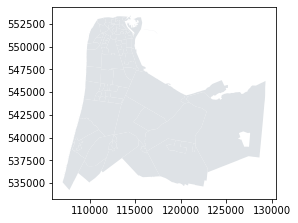

In [23]:
zones_maxdepth_arrival_df, zones_depth_time_df = create_zones_maxdepth_arrival_df(houses_all, selected_zones, samplesize_nr_houses_in_zone, scenario_name, gr, time_humanized, last_timestamp, output_path)

------------------------------------------

In [24]:
zones_maxdepth_arrival_df.head(3)

,BU_NAAM,geometry,AANT_INW,maxdepth,maxdepth_qt,arrival
49,Blauwe Keet,"POLYGON ((112962.203 547568.188, 113580.000 54...",45,1.708696,1.561553,2000-01-01 02:00:04
68,'t Zand-West- en -Zuid,"POLYGON ((112411.071 539578.531, 112435.289 53...",840,NaN,NaN,NaN
54,Ooghduyne,"POLYGON ((109646.602 546255.813, 109845.398 54...",170,1.162799,1.065256,2000-01-01 03:20:00


In [25]:
zones_depth_time_df.tail()

,Blauwe Keet,Ooghduyne,Fort Dirksz Admiraal,Middelzand,Zwanenbalg,Fort Erfprins,Kolksluis,Noorderhaven,Liniebuurt,Grachtengordel,...,Huisduinen,Tuindorp-Oost,Oostsloot,Indische buurt-Zuid,Nieuw Den Helder Zuid-Oost,Duinbuurt,Guldemond,Vogelzand,Van Galenbuurt,Mijnendienst
2000-01-02 13:40:34,1.270226,0.772845,0.289019,0.597614,0.776238,0.782407,0.185,0.850019,0.774246,0.709157,...,0.002684,0.707719,0.844120,0.588238,0.373944,0.179049,0.404931,0.983726,0.707049,1.184355
2000-01-02 13:45:05,1.269569,0.772190,0.288470,0.596958,0.775582,0.781755,0.185,0.849363,0.773647,0.708644,...,0.002684,0.707206,0.843642,0.587757,0.373292,0.178488,0.404313,0.983071,0.706583,1.183845
2000-01-02 13:50:14,1.268825,0.771446,0.287847,0.596209,0.774840,0.780919,0.185,0.848617,0.772869,0.708042,...,0.002684,0.706610,0.843083,0.587168,0.372554,0.177851,0.403609,0.982325,0.706028,1.183235
2000-01-02 13:55:22,1.268086,0.770705,0.287222,0.595469,0.774102,0.780092,0.185,0.847876,0.772003,0.707428,...,0.002684,0.706002,0.842512,0.586531,0.371819,0.177218,0.402910,0.981583,0.705446,1.182623
2000-01-02 14:00:31,1.267345,0.769969,0.286589,0.594734,0.773365,0.779334,0.185,0.847140,0.771148,0.706808,...,0.002684,0.705388,0.841920,0.585847,0.371084,0.176584,0.402206,0.980848,0.704831,1.181998


In [16]:
# zones_maxdepth_arrival_df_dropna = zones_maxdepth_arrival_df.dropna()

In [26]:
#datetime to string for export
zones_maxdepth_arrival_df_str = zones_maxdepth_arrival_df.copy()
zones_maxdepth_arrival_df_str['arrival'] = zones_maxdepth_arrival_df["arrival"].apply(str)
zones_maxdepth_arrival_df_str.to_file(f'{output_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.geojson', drive="GeoJSON")


## WRITING FILES ##
zones_depth_time_df.to_json(f'{output_path}/zones_depth_time_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.json')


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

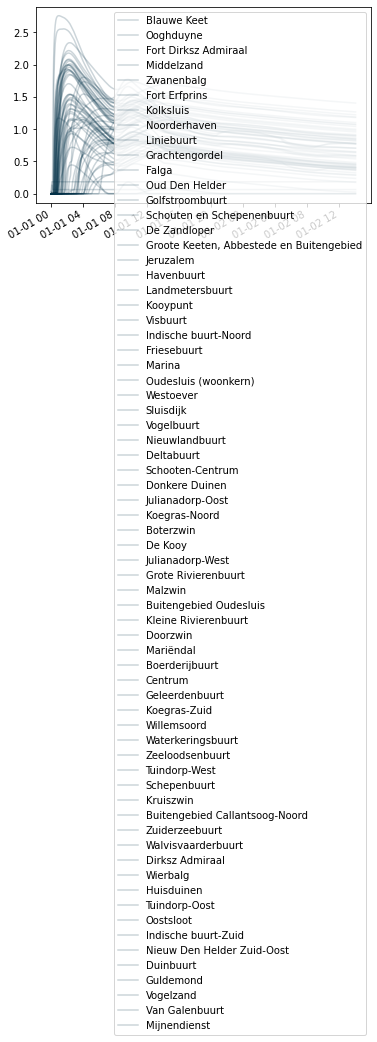

In [30]:
zones_depth_time_df.plot(color = '#023047', alpha= 0.2)
